In [75]:
import json
from web3 import Web3
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
def check_swap_transactions(tx, router_address, abi_file='uniswap_router02.json'):
    function_names = ['swapExactTokensForTokens', 'swapExactETHForTokens', 'swapTokensForExactETH']
    INFURA_URL = "https://mainnet.infura.io/v3/b55d7663dd3547f3b1bd7b7a89e678ac"
    web3 = Web3(Web3.HTTPProvider(INFURA_URL))
    with open(abi_file, 'r') as file:
        router_abi = json.load(file)

    contract = web3.eth.contract(address=router_address, abi=router_abi)
    decoded_input = contract.decode_function_input(tx['input'])
    function_name = decoded_input[0].fn_name
    function_args = decoded_input[1]

    if function_name in function_names:
        path = function_args['path']
        token_abi = [
        {
            "constant": True,
            "inputs": [],
            "name": "decimals",
            "outputs": [{"name": "", "type": "uint8"}],
            "type": "function",
        },
        {
            "constant": True,
            "inputs": [],
            "name": "symbol",
            "outputs": [{"name": "", "type": "string"}],
            "type": "function",
        },
    ]
        
        
        try:
            token_contract = web3.eth.contract(address=path[0], abi=token_abi)
            tokenIn_symbol = token_contract.functions.symbol().call()
            decimals_in = token_contract.functions.decimals().call()
        except Exception as e:
            tokenIn_symbol = "UNKNOWN"
            decimals_in = -1
        
        try:
            token_contract = web3.eth.contract(address=path[-1], abi=token_abi)
            tokenOut_symbol = token_contract.functions.symbol().call()
            decimals_out = token_contract.functions.decimals().call()
        except Exception as e:
            tokenOut_symbol = "UNKNOWN"
            decimals_out = -1
        
        if function_name == 'swapExactTokensForTokens':
            return function_name, function_args['amountIn']/(10 ** decimals_in), function_args['amountOutMin']/(10 ** decimals_out), path, len(path), tokenIn_symbol, tokenOut_symbol
        elif function_name == 'swapExactETHForTokens':
            return function_name, tx['value']/(10 ** decimals_in), function_args['amountOutMin']/(10 ** decimals_out), path, len(path), tokenIn_symbol, tokenOut_symbol
        elif function_name == 'swapTokensForExactETH':
            return function_name, function_args['amountInMax']/(10 ** decimals_in), function_args['amountOut']/(10 ** decimals_out), path, len(path), tokenIn_symbol, tokenOut_symbol
    
    return None, None, None, None, None, None, None




def count_dex_transactions(blocks, dex_router, cex_router):
    INFURA_URL = "https://mainnet.infura.io/v3/b55d7663dd3547f3b1bd7b7a89e678ac"
    web3 = Web3(Web3.HTTPProvider(INFURA_URL))

    block_dex_deals = {}
    block_arbitr_deals = {}
    token_stats = {}
    block_path = {}

    for b in blocks:
        block = web3.eth.get_block(b, full_transactions=True)
        txs = block['transactions']
        idx_dex = {}
        idx_not_dex = {}
        
        for i, tx in enumerate(txs):
            if tx['to'] in dex_router:
                # amount_in, amount_out -- how many tokens do we sell and receive
                # token_in, token_out -- symbols of the tokens that we sell and receive
                function_name, amount_in, amount_out, path, num_tokens, token_in, token_out = check_swap_transactions(tx, dex_router[0])
                
                if function_name:
                    if tx['from'] not in idx_dex.keys():
                        idx_dex[tx['from']] = [i]
                    else:
                        idx_dex[tx['from']].append(i)

                    if b not in block_dex_deals.keys():
                        block_dex_deals[b] = 1
                        block_path[b] = [[amount_in, amount_out, num_tokens, token_in, token_out]]
                    else:
                        block_dex_deals[b] += 1
                        block_path[b].append([amount_in, amount_out, num_tokens, token_in, token_out])

            else:
                if tx['from'] not in idx_not_dex.keys():
                    idx_not_dex[tx['from']] = [i]
                else:
                    idx_not_dex[tx['from']].append(i)
        
        common_senders = set(idx_dex.keys()) & set(idx_not_dex.keys())
        block_arbitr_deals[b] = len(common_senders)
                    
    return block_dex_deals, block_arbitr_deals, block_path

In [77]:
INFURA_URL = "https://mainnet.infura.io/v3/b55d7663dd3547f3b1bd7b7a89e678ac"
web3 = Web3(Web3.HTTPProvider(INFURA_URL))

latest_block = web3.eth.block_number
print(f"Последний номер блока: {latest_block}")

Последний номер блока: 21350488


In [ ]:
blocks = range(12343677, 12343777, 1)
# blocks = [12343677]
# blocks = range(21350181, 21350281, 1)
# blocks = range(21350081, 21350181, 1)
# blocks = range(12343877, 12343977, 1)
dex_router = ['0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D']
cex_router = [
    "0x28c6c06298d514db089934071355e5743bf21d60",  # Binance Hot Wallet
    "0x8f22f2063d253846b53609231ed80fa571bc2e0f",  # Coinbase Wallet (ETH)
    "0x0a869d79a7052c7f1b55a8ebabbea3420f0d1e13",  # Kraken Wallet
    "0xDC76CD25977E0A5Ae17155770273aD58648900D3",  # Huobi Hot Wallet
    "0xa6a5f4c502f7fa1d22d8c13f23ed6927df9a6ec7",  # KuCoin Hot Wallet
    "0x876eabf441b2ee5b5b0554fd502a8e0600950cfa",  # Bitfinex Wallet (ETH)
    "0x5c985e89dde482efe97ea9f1950ad149eb73829b",  # OKX Wallet
    "0x3f5ce5fbfe3e9af3971ddf4b9d51841c90696e43",  # Gate.io Hot Wallet
    "0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2",  # Bybit Wallet
    "0x401F6c983eA34274ec46f84D70b31C151321188b"   # Bitstamp Wallet
]

block_dex_deals, block_arbitr_deals, block_paths = count_dex_transactions(blocks, dex_router, cex_router)

In [ ]:
block_paths # {block: [amount token in, amount token out, numner of tokens in one deal, symbol of token in, symbol of token out]}

In [96]:
pairs = []

for block, transactions in block_paths.items():
    for transaction in transactions:
        token_in = transaction[3]
        token_out = transaction[4]
        pairs.append((token_in, token_out))

pair_counts = Counter(pairs)
most_common_pair, count = pair_counts.most_common(1)[0]
print(f"The most popular pair: {most_common_pair}, occurs {count} times in 100 blocks")

The most popular pair: ('WETH', 'SHIB'), occurs 148 times in 100 blocks


In [97]:
pair_counts.most_common(20)

[(('WETH', 'SHIB'), 148),
 (('WETH', 'Selinu'), 74),
 (('WETH', 'TRU'), 53),
 (('WETH', 'URQA'), 49),
 (('WETH', 'ELON'), 35),
 (('WETH', 'BULL'), 31),
 (('WETH', 'CC'), 29),
 (('WETH', 'CARDS'), 26),
 (('WETH', 'eRSDL'), 23),
 (('WETH', 'RDOGE'), 21),
 (('WETH', 'KISHU'), 20),
 (('WETH', 'HOKK'), 18),
 (('WETH', 'C3'), 15),
 (('WETH', 'Pikachu'), 12),
 (('WETH', 'CDOGE'), 11),
 (('WETH', 'ELONONE'), 10),
 (('WETH', 'NAOS'), 9),
 (('WETH', 'SWM'), 9),
 (('WETH', 'SFI'), 9),
 (('USDC', 'URQA'), 9)]

In [ ]:
with open("block_dex_deals.json", "w") as file:
    json.dump(block_dex_deals, file, indent=4)

with open("block_arbitr_deals.json", "w") as file:
    json.dump(block_arbitr_deals, file, indent=4)

with open("block_paths.json", "w") as file:
    json.dump(block_paths, file, indent=4)

In [95]:
with open("block_dex_deals.json", "r") as file:
    block_dex_deals = json.load(file)

with open("block_arbitr_deals.json", "r") as file:
    block_arbitr_deals = json.load(file)

with open("block_paths.json", "r") as file:
    block_paths = json.load(file)

In [87]:
token_in_name_amount = {}
token_out_name_amount = {}
token_in_name_amount_sum = {}
token_out_name_amount_sum = {}
token_in_name_count = {}
token_out_name_count = {}


for arrs in block_paths.values():
    for params in arrs:
        amount_in, amount_out, token_in, token_out = params[0], params[1], params[3], params[4]
        if token_in not in token_in_name_amount:
            token_in_name_amount[token_in] = [amount_in]
            token_in_name_amount_sum[token_in] = amount_in
            token_in_name_count[token_in] = 1
        else:
            token_in_name_amount[token_in].append(amount_in)
            token_in_name_amount_sum[token_in] += amount_in
            token_in_name_count[token_in] += 1

        if token_out not in token_out_name_amount:
            token_out_name_amount[token_out] = [amount_out]
            token_out_name_amount_sum[token_out] = amount_out
            token_out_name_count[token_out] = 1
        else:
            token_out_name_amount[token_out].append(amount_out)
            token_out_name_amount_sum[token_out] += amount_out
            token_out_name_count[token_out] += 1

In [88]:
token_in_name_amount_sum_sorted = dict(sorted(token_in_name_amount_sum.items(), key=lambda item: item[1], reverse=True))
token_out_name_amount_sum_sorted = dict(sorted(token_out_name_amount_sum.items(), key=lambda item: item[1], reverse=True))

token_in_name_count_sorted = dict(sorted(token_in_name_count.items(), key=lambda item: item[1], reverse=True))
token_out_name_count_sorted = dict(sorted(token_out_name_count.items(), key=lambda item: item[1], reverse=True))

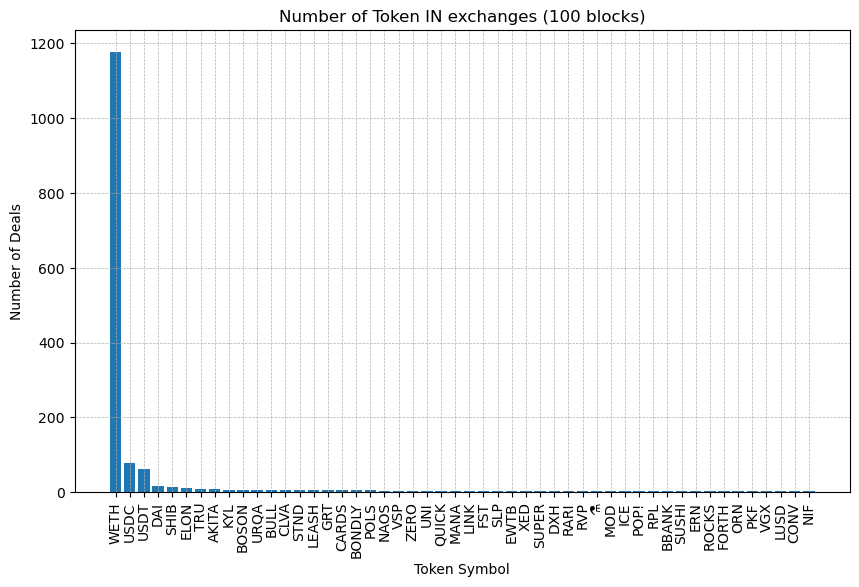

In [89]:
plt.figure(figsize=(10, 6))
plt.bar(list(token_in_name_count_sorted.keys())[:50], list(token_in_name_count_sorted.values())[:50])

plt.xlabel('Token Symbol')
plt.ylabel('Number of Deals')
plt.xticks(rotation=90)
plt.title('Number of Token IN exchanges (100 blocks)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

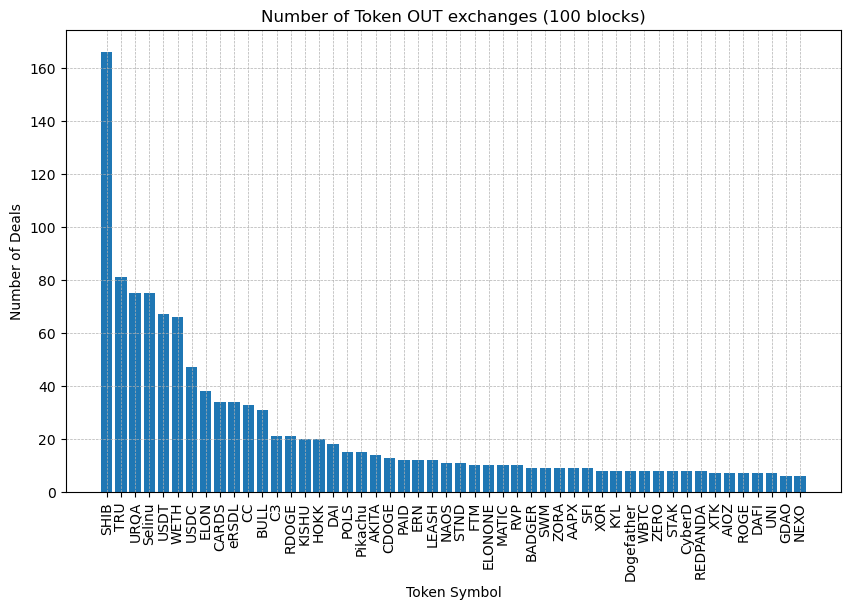

In [90]:
plt.figure(figsize=(10, 6))
plt.bar(list(token_out_name_count_sorted.keys())[:50], list(token_out_name_count_sorted.values())[:50])

plt.xlabel('Token Symbol')
plt.ylabel('Number of Deals')
plt.xticks(rotation=90)
plt.title('Number of Token OUT exchanges (100 blocks)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [100]:
block_num_weth_in = []
block_num_weth_out = []

block_num_usdt_in = []
block_num_usdt_out = []

block_num_usdc_in = []
block_num_usdc_out = []

block_num_weth_usdc = []
block_num_weth_usdt = []

block_num_usdc_weth = []
block_num_usdt_weth = []

block_num_weth_shib = []

num_weth = []

for k, v in block_paths.items():
    arr_tmp_in = []
    arr_tmp_out = []

    arr_tmp_in_ut = []
    arr_tmp_out_ut = []

    arr_tmp_in_uc = []
    arr_tmp_out_uc = []

    
    for arr in block_paths[k]:

        if arr[3] == 'WETH':
            arr_tmp_in.append(arr[0])
        if arr[4] == 'WETH':
            arr_tmp_out.append(arr[1])

        if arr[3] == 'USDT':
            arr_tmp_in_ut.append(arr[0])
        if arr[4] == 'USDT':
            arr_tmp_out_ut.append(arr[1])

        if arr[3] == 'USDC':
            arr_tmp_in_uc.append(arr[0])
        if arr[4] == 'USDC':
            arr_tmp_out_uc.append(arr[1])
        
        if arr[3] == 'WETH' and arr[4] == 'USDT':
            block_num_weth_usdt.append([arr[0], arr[1]])
        if arr[3] == 'WETH' and arr[4] == 'USDC':
            block_num_weth_usdc.append([arr[0], arr[1]])
        
        if arr[4] == 'WETH' and arr[3] == 'USDT':
            block_num_usdt_weth.append([arr[0], arr[1]])
        if arr[4] == 'WETH' and arr[3] == 'USDC':
            block_num_usdc_weth.append([arr[0], arr[1]])

        if arr[3] == 'WETH' and arr[4] == 'SHIB':
            block_num_weth_shib.append([arr[0], arr[1]])

        if arr[3] == 'WETH':
            num_weth.append(arr[0])
            
    block_num_weth_in.append(arr_tmp_in)
    block_num_weth_out.append(arr_tmp_out)
    block_num_usdt_in.append(arr_tmp_in_ut)
    block_num_usdt_out.append(arr_tmp_out_ut)
    block_num_usdc_in.append(arr_tmp_in_uc)
    block_num_usdc_out.append(arr_tmp_out_uc)

In [101]:
block_num_weth_usdt, block_num_weth_usdc

([[8.11, 22254.429515],
  [0.2, 543.44815],
  [37.0, 100495.233343],
  [0.15285622372, 419.466277],
  [0.5, 1359.321544]],
 [[18.0, 45310.829596],
  [15.0, 41329.942582],
  [0.74, 2039.332457],
  [2.9, 7991.747824],
  [7.0, 19325.716863],
  [4.0, 11017.446209],
  [6.402262583500271, 17224.936353]])

In [104]:
np.mean(num_weth), np.std(num_weth)

(0.8953240983845553, 2.4183111707476863)